# Capstone Project
## Find an Ice Cream Parlor Location in Chicago, IL

## Table of contents
* [Introduction](#introduction)
* [Methodology](#methodology)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
* [References](#references)

## Introduction <a name="introduction"></a>

A new client is looking for an ideal location to open an ice cream parlor in Chicago, IL (USA).  She hired us to use location data to identify key metrics that will aid in location selection.   We used Foursquare location data to identify venues that indicate the existence of a large potential customer base in the neighborhoods of Chicago.  We also used it to identify existing competitor businesses in those locations with a large number of potential customers.  An ideal location will have a large number of potential customers and relatively low competition.  

## Methodology <a name="methodology"></a>

In this project we sought to identify an ideal location in Chicago to open an ice cream parlor.  We found a list of all of neighborhoods on Wikipedia and used Google maps to obtain the latitude and longitude for each.  

We then identified the locations of schools, parks, beaches and other venues that serve as probable indicators of nearby customers.  Together these should be a strong indication that large numbers of customers are regularly in the vicinity.  We also gathered data on the location of competitor businesses to determine likely competition for the new business.  

We chose k-means clustering to analyze the customer and competitor data sets.  These data points were then compared directly.   


## Data <a name="data"></a>

First we found a comprehensive list of Chicago neighborhoods on Wikipedia.  Chicago is a very large city and upon consulting the client, a smaller area was chosen.  It consists of the community areas Near North Side, West Town, Lincoln Park, Lakeview, Logan Square, Avondale, North Center and Uptown.  This is essentially the neighborhoods north of the Chicago Loop area and is convenient to where the client lives.   

The next focus was identifying venues that indicated a large potential customer base.  Schools may be helpful to identify areas where families live while other factors such as parks and beaches will draw customers from surrounding areas.  Additional businesses like movie theatres and bowling alleys may also indicate potential customers.  We used geolocation to identify the location of these types of venues.

Finally, after identifying areas with large potential customer bases we plan to find nearby competitor businesses including other ice cream parlors.  A certain density of competitors may indicate a poor location choice depending on the size of the potential customer base.  


In [1]:
# import all necessary libraries

from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import ssl
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
from folium.plugins import FastMarkerCluster

import googlemaps

import matplotlib.pyplot as plt 
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

import os

print('Libraries imported.')


Libraries imported.


An excellent list of Chicago neighborhoods is available on Wikipedia.  Read that in here using beautiful soup and convert to a dataframe.

In [2]:
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE
html = urlopen('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago', context=ctx).read()
soup = BeautifulSoup(html, "html.parser")
table = soup.find_all('table')[0]
chicago_neighborhoods = pd.read_html(str(table))[0]

This list is comprehensive and includes every neighborhood of Chicago so let's reduce it to the specific areas of interest. 

In [3]:
reduced_area_list = ['Near North Side', 'West Town', 'Lincoln Park', 'Lake View', 'Logan Square', 'North Center']
chicago_neighborhoods = chicago_neighborhoods.loc[chicago_neighborhoods['Community area'].isin(reduced_area_list)]
chicago_neighborhoods.drop(columns = ['Community area'], inplace = True)
chicago_neighborhoods = chicago_neighborhoods.reset_index(drop=True)

Use Google maps to find the latitude and longitude for each neighborhood.  

In [4]:
api_key = 'sensitive content' # enter your google api key here

In [5]:
# define function to open existing files to avoid reproducing prior work and exceeding api quotas
def file_check(file_name):
    return os.path.isfile(file_name)

gmaps = googlemaps.Client(key=api_key)

# try to read in this information from csv if done previously
if file_check('chicago_neighborhoods.csv') == True:
    chicago_neighborhoods = pd.read_csv('chicago_neighborhoods.csv')
    chicago_neighborhoods = chicago_neighborhoods.drop(columns = ['Unnamed: 0'])
    print("Read in from csv file!")
    
# otherwise, get the lat/lng data from Google
else:
    for index, row in chicago_neighborhoods.iterrows():
        loc = row['Neighborhood'] + ', Chicago, IL'
        geocode_result = gmaps.geocode(loc)
        result = geocode_result[0]
        chicago_neighborhoods.at[index, 'Latitude'] = result.get('geometry').get('location').get('lat')
        chicago_neighborhoods.at[index, 'Longitude'] = result.get('geometry').get('location').get('lng')
    # If no csv file exists, create it to avoid using quota of api calls
    chicago_neighborhoods.to_csv('chicago_neighborhoods.csv')

Read in from csv file!


In [6]:
chicago_neighborhoods

,Neighborhood,Latitude,Longitude
0,Boystown,41.943998,-87.647385
1,Bucktown,41.922707,-87.680275
2,Cabrini–Green,41.901091,-87.641464
3,East Village,41.899811,-87.672294
4,Gold Coast,41.906699,-87.625331
5,Goose Island,41.904455,-87.654414
6,Graceland West,41.959951,-87.668074
7,Kosciuszko Park,41.930969,-87.725002
8,Lake View,41.939781,-87.658927
9,Lake View East,41.941358,-87.644309


This is our final list of Chicago neighborhoods to focus our search with latitude and longitude information included.  Let's see this on a map.  

In [7]:
# create map of Chicago centered on latitude and longitude values for Lincoln Park
latitude = chicago_neighborhoods.loc[10, 'Latitude'] # neighborhood latitude value
longitude = chicago_neighborhoods.loc[10, 'Longitude'] # neighborhood longitude value
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add neighborhood markers to map
for lat, lng, neighborhood in zip(chicago_neighborhoods['Latitude'], chicago_neighborhoods['Longitude'], chicago_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  

map_chicago

This looks good.  Moreover, the neighborhoods are somewhat evenly spaced, which is helpful.  They can now be used to find nearby indicators of potential customers to create a comprehensive list.  Indeed, the list will need to have duplicates removed. To help illustrate this point, add red circles around each neighborhood with a radius of 1000m. 

In [8]:
# create map of Chicago centered on latitude and longitude values for Lincoln Park
latitude = chicago_neighborhoods.loc[10, 'Latitude'] # neighborhood latitude value
longitude = chicago_neighborhoods.loc[10, 'Longitude'] # neighborhood longitude value
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add neighborhood markers to map
for lat, lng, neighborhood in zip(chicago_neighborhoods['Latitude'], chicago_neighborhoods['Longitude'], chicago_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
        
    folium.Circle([lat,lng], radius =1000, color = 'red').add_to(map_chicago)
map_chicago

We should have no trouble collecting data on the locations of potential customer indicators and competitors. 

In [9]:
CLIENT_ID = 'sensitive content' #Enter Foursquare ID
CLIENT_SECRET = 'sensitive content' #Enter Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [10]:

#positive indicators of potential customers categories
elementary_school_category = '4f4533804b9074f6e4fb0105'
middle_school_category = '4f4533814b9074f6e4fb0106'
high_school_category = '4bf58dd8d48988d13d941735'
parks_category = '4bf58dd8d48988d163941735'
pools_category = '4bf58dd8d48988d163941735'
beaches_category = '4bf58dd8d48988d1e2941735'
bowling_alleys_category = '4bf58dd8d48988d1e4931735'
mini_golf_category = '52e81612bcbc57f1066b79eb'
movie_theatres_category = '4bf58dd8d48988d17f941735'
roller_rinks_category = '52e81612bcbc57f1066b79e9'

cust_indicator_categories = ['4f4533804b9074f6e4fb0105', '4f4533814b9074f6e4fb0106', '4bf58dd8d48988d13d941735', 
                             '4bf58dd8d48988d163941735', '4bf58dd8d48988d163941735', '4bf58dd8d48988d1e2941735',
                             '4bf58dd8d48988d1e4931735', '52e81612bcbc57f1066b79eb', 
                             '4bf58dd8d48988d17f941735', '52e81612bcbc57f1066b79e9']

#compeititor categories are conveniently a general category labeled 'Dessert Shop'
competition_categories = '4bf58dd8d48988d1d0941735'

The categories above are strong indicators of potential customers and we wish to find all of them near our neighborhood centers using Foursquare.  We'll then do the same for competitor businesses.  

In [11]:
# function that extracts the category type of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
# function that extracts the category id of the venue
def get_category_id(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['id']

In [12]:

# define function to search by category ID
def foursquare_catid_search(cat_id):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, cat_id, radius, LIMIT)

    results = requests.get(url).json()
    if not results:
        return

    # assign relevant part of JSON to venues
    try:
        venues = results['response']['venues']
    except:
        return
    if not venues:
        return

    dataframe = json_normalize(venues)
    
    # keep only columns that include venue name and location info
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    
    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    
    return dataframe_filtered


In [13]:

# Try to read from file in case we've already done this to avoid exceeding api call quota
if file_check('customer_indicator_locations.csv') == True:
    customer_indicator_locations = pd.read_csv('customer_indicator_locations.csv')
    customer_indicator_locations = customer_indicator_locations.drop(columns = ['Unnamed: 0'])
    customer_indicator_locations.head()
    print("Read in from csv file!")

else:
    radius = 1000
    LIMIT = 100
    customer_indicator_locations = pd.DataFrame()
    
    # loop through chicago neighborhoods to look up customer indicator locations
    for index, row in chicago_neighborhoods.iterrows():    
        latitude = row['Latitude']
        longitude = row['Longitude']

        # loop through customer indicator categories within each neighborhood 
        for c in cust_indicator_categories:
            search_results = foursquare_catid_search(c)
            customer_indicator_locations = customer_indicator_locations.append(search_results, ignore_index = True)
            
    # remove duplicates based on each location having a unique 'id'
    customer_indicator_locations.drop_duplicates('id', inplace = True)
    # create csv file for future use
    customer_indicator_locations.to_csv('customer_indicator_locations.csv')
customer_indicator_locations.head()

Read in from csv file!


,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state
0,2648 W Fullerton Ave,Bowling Alley,US,Chicago,United States,btwn Washtenaw Ave & Talman Ave,664,['2648 W Fullerton Ave (btwn Washtenaw Ave & T...,40b28c80f964a520d4fe1ee3,"[{'label': 'display', 'lat': 41.92495760463575...",41.924958,-87.694395,Fireside Bowl,NaN,60647.0,IL
1,3145 N Sheffield Ave,Music Venue,US,Chicago,United States,btwn W Fletcher St & W Belmont Ave,734,['3145 N Sheffield Ave (btwn W Fletcher St & W...,417c4200f964a520ca1d1fe3,"[{'label': 'display', 'lat': 41.93954700830196...",41.939547,-87.653929,The Vic Theatre,NaN,60657.0,IL
2,3325 N Southport Ave,Bowling Alley,US,Chicago,United States,at W Henderson St,495,"['3325 N Southport Ave (at W Henderson St)', '...",4276bf00f964a52089211fe3,"[{'label': 'display', 'lat': 41.94237267739185...",41.942373,-87.663788,Southport Lanes & Billiards,NaN,60657.0,IL
3,201 E Randolph St,Park,US,Chicago,United States,btwn Columbus Dr & Michigan Ave,1152,['201 E Randolph St (btwn Columbus Dr & Michig...,42b75880f964a52090251fe3,NaN,41.882693,-87.623442,Millennium Park,The Loop,60601.0,IL
4,3733 N Southport Ave,Indie Movie Theater,US,Chicago,United States,btwn Grace St & Waveland Ave,1195,['3733 N Southport Ave (btwn Grace St & Wavela...,42e82000f964a52086261fe3,"[{'label': 'display', 'lat': 41.94986083017660...",41.949861,-87.663920,Music Box Theatre,NaN,60613.0,IL


In [14]:
customer_indicator_locations.shape

(587, 16)

Our refined list of customer indicator locations is 587 distinct venues.  Let's look at these on a map.  

In [15]:
# Lincoln Park is roughly the center of our area of interest so center the map there
latitude = chicago_neighborhoods.loc[10, 'Latitude']
longitude = chicago_neighborhoods.loc[10, 'Longitude'] 

customer_indicator_locations_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map

# add the search results as blue circle markers
for lat, lng, label in zip(customer_indicator_locations['lat'], customer_indicator_locations['lng'], customer_indicator_locations['id']):
    folium.features.CircleMarker(
        [lat, lng],
        radius = 3,
        color = 'blue',
        popup = folium.Popup(label, parse_html = True, max_width =100),
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.6
    ).add_to(customer_indicator_locations_map)
#customer_indicator_locations_map.add_child(FastMarkerCluster(customer_indicator_locations[['lat', 'lng']].values.tolist()))
customer_indicator_locations_map

In [16]:
# Try to read from file in case we've already done this to avoid exceeding api call quota
if file_check('competition_locations.csv') == True:
    competition_locations = pd.read_csv('competition_locations.csv')
    competition_locations = competition_locations.drop(columns = ['Unnamed: 0'])
    competition_locations.head()
    print("Read in from csv file!")

else:
    radius = 1000
    LIMIT = 100
    competition_locations = pd.DataFrame()
    
    # loop through chicago neighborhoods to look up competition locations
    for index, row in chicago_neighborhoods.iterrows():    
        latitude = row['Latitude']
        longitude = row['Longitude']
        search_results = foursquare_catid_search(competition_categories)
        competition_locations = competition_locations.append(search_results, ignore_index = True)
            
# remove duplicates based on each location having a unique 'id'
competition_locations.drop_duplicates('id', inplace = True)

# create csv for future use
competition_locations.to_csv('competition__locations_raw.csv')

competition_locations.head()    

Read in from csv file!


,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state
0,3510 N Halsted St,Frozen Yogurt Shop,US,Chicago,United States,btwn Brompton & Cornelia Ave,260,['3510 N Halsted St (btwn Brompton & Cornelia ...,4f889f65e4b04a075de5a990,"[{'label': 'display', 'lat': 41.94574576918767...",41.945746,-87.649474,Forever Yogurt,NaN,60657.0,IL
1,613 W Diversey Pkwy,Ice Cream Shop,US,Chicago,United States,NaN,1264,"['613 W Diversey Pkwy', 'Chicago, IL 60614', '...",4e4e09b6bd4101d0d7a0c9d7,"[{'label': 'display', 'lat': 41.932872, 'lng':...",41.932872,-87.644314,Cold Stone Creamery,NaN,60614.0,IL
2,NaN,Ice Cream Shop,US,Chicago,United States,NaN,863,"['Chicago, IL 60657', 'United States']",5c8ec19ff193c0002c491c15,"[{'label': 'display', 'lat': 41.936569, 'lng':...",41.936569,-87.644382,Johnson’s Real Ice Cream,NaN,60657.0,IL
3,3055 N Sheffield Ave,Dessert Shop,US,Chicago,United States,NaN,860,"['3055 N Sheffield Ave', 'Chicago, IL 60657', ...",5758ed15498e8e720571222b,"[{'label': 'display', 'lat': 41.93795890664535...",41.937959,-87.653870,Oberweis Ice Cream and Dairy Store,NaN,60657.0,IL
4,3308 N Broadway St,Candy Store,US,Chicago,United States,at W Aldine Ave,316,"['3308 N Broadway St (at W Aldine Ave)', 'Chic...",4a160b04f964a520e9781fe3,"[{'label': 'display', 'lat': 41.94216229475295...",41.942162,-87.644466,Windy City Sweets,NaN,60657.0,IL


In [17]:
competition_locations.shape

(274, 16)

We've identified 274 distinct competitor businesses.  Let's look at these on a map.  

In [18]:
# Lincoln Park is roughly the center of our area of interest so center the map there
latitude = chicago_neighborhoods.loc[10, 'Latitude']
longitude = chicago_neighborhoods.loc[10, 'Longitude'] 

competition_locations_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map

# add the search results as blue circle markers
for lat, lng, label in zip(competition_locations['lat'], competition_locations['lng'], competition_locations['id']):
    folium.features.CircleMarker(
        [lat, lng],
        radius = 3,
        color = 'red',
        popup = folium.Popup(label, parse_html = True, max_width =100),
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(competition_locations_map)
#customer_indicator_locations_map.add_child(FastMarkerCluster(customer_indicator_locations[['lat', 'lng']].values.tolist()))
competition_locations_map

This concludes data collection.  

## Analysis <a name="analysis"></a>

We first want to use k-means clustering to identify locations with large potential customer pools.  Let's simplify things for the moment and look at a scatter plot

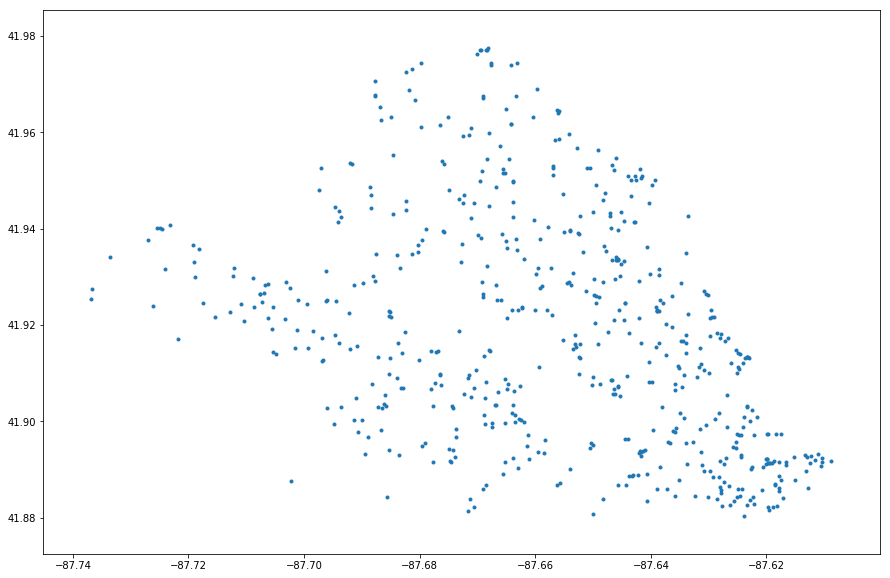

In [19]:
X = customer_indicator_locations[['lng','lat']].values
plt.figure(figsize=(15, 10))
plt.scatter(X[:, 0], X[:, 1], marker='.')

This looks like good data on which to a perform k-means clustering analysis.  Let's start by plotting the number of clusters vs the sum of squared distances and use the elbow method to choose the appropriate number of clusters.  

Text(0, 0.5, 'Sum of squared error')

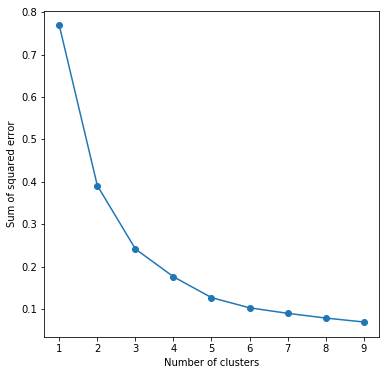

In [20]:
sse = []
for k in range(1,10):
    kmeans = KMeans(n_clusters = k).fit(X)
    sse.append(kmeans.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(range(1,10), sse, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared error')

The above plot doesn't reveal a sharp elbow but 5 appears to be an appropriate maxiumum number of clusters to choose. 

In [21]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
cluster_centers = [(cc[0], cc[1]) for cc in kmeans.cluster_centers_]
cluster_centers

[(-87.64734216222222, 41.92906912569445),
 (-87.67415143656862, 41.90137818029412),
 (-87.70459773333333, 41.926875225138886),
 (-87.67075122680413, 41.95574261381444),
 (-87.62826802848838, 41.89573289476744)]

In [22]:
cluster_centers_df = pd.DataFrame(cluster_centers)
cluster_centers_df.columns = ['lng', 'lat']
cluster_centers_df

,lng,lat
0,-87.647342,41.929069
1,-87.674151,41.901378
2,-87.704598,41.926875
3,-87.670751,41.955743
4,-87.628268,41.895733


In [23]:

latitude = chicago_neighborhoods.loc[10, 'Latitude']
longitude = chicago_neighborhoods.loc[10, 'Longitude'] 

customer_indicator_locations_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map

# add the search results as blue circle markers
for lat, lng, label in zip(customer_indicator_locations['lat'], customer_indicator_locations['lng'], customer_indicator_locations['id']):
    folium.features.CircleMarker(
        [lat, lng],
        radius = 3,
        color = 'blue',
        popup = folium.Popup(label, parse_html = True, max_width =100),
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.6
    ).add_to(customer_indicator_locations_map)

for lat, lng, centroid in zip(cluster_centers_df['lat'], cluster_centers_df['lng'], [0,1,2,3,4,5,6]):
    label = '{}'.format(centroid)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(customer_indicator_locations_map)
    
customer_indicator_locations_map

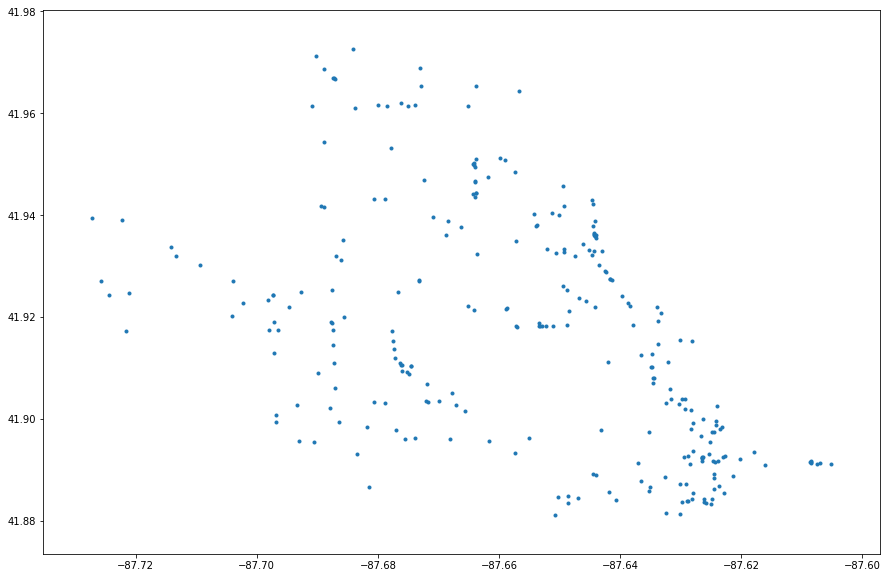

In [24]:
Xc = competition_locations[['lng','lat']].values
plt.figure(figsize=(15, 10))
plt.scatter(Xc[:, 0], Xc[:, 1], marker='.')

Again, this looks like good data on which to a perform k-means clustering analysis.  Let's use the elbow method to determine an appropriate number of clusters.

Text(0, 0.5, 'Sum of squared error')

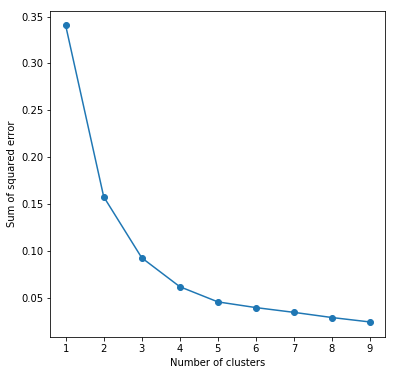

In [25]:
sse2 = []
for k in range(1,10):
    km = KMeans(n_clusters = k).fit(Xc)
    sse2.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(range(1,10), sse2, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared error')


Again, the plot does not have a sharp elbow but we chose 5 clusters

In [26]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(Xc)
comp_cluster_centers = [(cc[0], cc[1]) for cc in kmeans.cluster_centers_]
comp_cluster_centers

[(-87.6729242201036, 41.953722278664394),
 (-87.62823512392309, 41.892977875703465),
 (-87.67842191847787, 41.906345275713186),
 (-87.70420343625702, 41.92588313011351),
 (-87.64678321308978, 41.928081099911125)]

In [27]:
comp_cluster_centers_df = pd.DataFrame(comp_cluster_centers)
comp_cluster_centers_df.columns = ['lng', 'lat']
comp_cluster_centers_df

,lng,lat
0,-87.672924,41.953722
1,-87.628235,41.892978
2,-87.678422,41.906345
3,-87.704203,41.925883
4,-87.646783,41.928081


In [28]:
latitude = chicago_neighborhoods.loc[10, 'Latitude']
longitude = chicago_neighborhoods.loc[10, 'Longitude'] 

competition_locations_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map

# add the search results as blue circle markers
for lat, lng, label in zip(competition_locations['lat'], competition_locations['lng'], competition_locations['id']):
    folium.features.CircleMarker(
        [lat, lng],
        radius = 3,
        color = 'red',
        popup = folium.Popup(label, parse_html = True, max_width =100),
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(competition_locations_map)
    
for lat, lng, centroid in zip(comp_cluster_centers_df['lat'], comp_cluster_centers_df['lng'], [0,1,2,3,4,5,6]):
    label = '{}'.format(centroid)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(competition_locations_map)
    
competition_locations_map

Let's take a look at the customer cluster centers and the competition cluster centers on one map.

In [30]:

latitude = chicago_neighborhoods.loc[10, 'Latitude']
longitude = chicago_neighborhoods.loc[10, 'Longitude'] 

combined_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map


for lat, lng, centroid in zip(cluster_centers_df['lat'], cluster_centers_df['lng'], [0,1,2,3,4,5,6]):
    label = '{}'.format(centroid)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(combined_map)
    
for lat, lng, centroid in zip(comp_cluster_centers_df['lat'], comp_cluster_centers_df['lng'], [0,1,2,3,4,5,6]):
    label = '{}'.format(centroid)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(combined_map)
    
combined_map

## Results and Discussion <a name="results"></a>

These results are not entirely surprising.  The north side of Chicago where we focused our search is indeed a highly developed area of the city and competition among business owners in most categories is fierce.  While this is not an ideal result, it has the benefit of letting the potential business owner know the truth.  Yes, there are large pools of potential customers but competition is most likely unavoidable.  

Here are the major intersections closest to the customer data centroids:
* Division and Damen in Wicker Park
* Fullerton Ave, Lincoln Ave and Halstead St in Lincoln Park
* Ashland Ave and Irving Park Rd in Lakeview
* Chicago Ave and State St in River North
* Logan Blvd, Milwaukee Ave and Kedzie Blvd in Logan Square

The Division and Damen location has the most significant separation from a competition centroid but not so substantial as to make this the clear best location of the five.



## Conclusion <a name="conclusion"></a>

The hard truth is the area we focused on has a large number of competitor businesses already.  The area does manage to support all of them but a new ice cream parlor will face stiff competition and need to set itself apart from the rest to succeed.  Creating a unique business is potentially critical to success.  
Additional considerations such as visibility, availability, rent, etc are beyond the scope of this project but should be considered carefully before final location selection takes place.  These are likely to be critical to success as well.  
In closing, it is worth acknowledging that the data underlying this conclusion is not perfect and can be massaged to produce more favorable outcomes but that really does a disservice to the client.   


## References <a name="references"></a>

[Wikipedia Chicago Community Areas](https://en.wikipedia.org/wiki/Community_areas_in_Chicago)

[Wikipedia Chicago Neighborhoods](https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago)

[Google Maps Geocoding API](https://developers.google.com/maps/documentation/geocoding/intro)

[Foursquare API](https://developer.foursquare.com/)

Acknowledgement: code that was written for various labs throughout this course was used throughout this project.  Thank you to the creator(s) of that code for your assistance! 